## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [14]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [16]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 569s 3us/step


In [17]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [18]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [19]:
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 128, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [21]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 5
BATCH_SIZE = 256
# MOMENTUM = 0.95
Dropout_EXP = [0.7, 0.5, 0.4, 0.25, 0.1]

In [22]:
# Define results
results = {}
for dropout in Dropout_EXP :
    #       build_mlp(input_shape, output_units=10, num_neurons, drp_ratio=0.2)
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=dropout)

    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    name_tag_of_dropout = 'drop_rate_%.2f' % dropout
    results[name_tag_of_dropout] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc' : train_acc,
                         'valid-acc' : valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)

50000/50000 [==============================] - 9s 185us/step - loss: 2.2582 - acc: 0.1418 - val_loss: 2.1553 - val_acc: 0.1651
Epoch 2/5
50000/50000 [==============================] - 8s 161us/step - loss: 2.1404 - acc: 0.1677 - val_loss: 2.1421 - val_acc: 0.1801
Epoch 3/5
50000/50000 [==============================] - 8s 162us/step - loss: 2.1107 - acc: 0.1746 - val_loss: 2.1418 - val_acc: 0.1645
Epoch 4/5
50000/50000 [==============================] - 8s 160us/step - loss: 2.0916 - acc: 0.1816 - val_loss: 2.1155 - val_acc: 0.1742
Epoch 5/5
50000/50000 [==============================] - 8s 156us/step - loss: 2.0798 - acc: 0.1874 - val_loss: 2.1151 - val_acc: 0.1716
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               157337

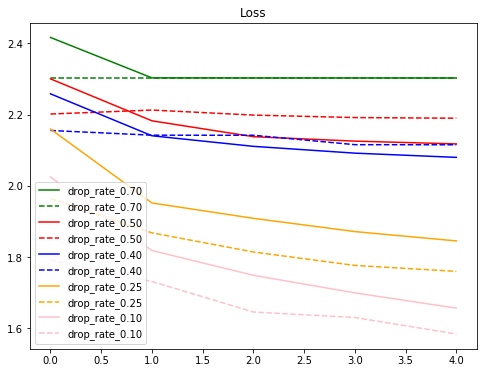

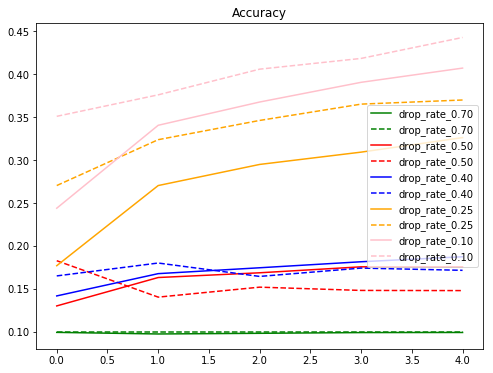

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["g", "r", "b", "orange", "pink"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.legend()
plt.title("Loss")
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.legend()
plt.title("Accuracy")
plt.show()